<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculate-albedo" data-toc-modified-id="Calculate-albedo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate albedo</a></span></li>


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"

In [11]:
chunk_dict = {"time":500, "lat":400, "lon":1440} # "grid_size":500000}
chunk_dictn = {"time":100, "ncells":100} 

sa_olr = xr.open_dataset(ap.get_file("SAM", "rlt"), chunks=chunk_dict).rlt
sa_swn = xr.open_dataset(ap.get_file("SAM", "rst"), chunks=chunk_dict).rstacc
ds = xr.open_dataset(ap.get_file("DATA", "rad"), chunks=chunk_dict)
da_olr = ds.adj_atmos_lw_up_all_toa_1h
da_swu = ds.adj_atmos_sw_up_all_toa_1h
da_swd = ds.adj_atmos_sw_down_all_toa_1h
ni_olr = xr.open_dataset(ap.get_file("NICAM", "rlut"), chunks=chunk_dict).rlut
ni_swu = xr.open_dataset(ap.get_file("NICAM", "rsut"), chunks=chunk_dict).rsut
ni_swd = xr.open_dataset(ap.get_file("NICAM", "rsdt"), chunks=chunk_dict).rsdt
um_olr = xr.open_dataset(ap.get_file("UM", "rlut"), chunks=chunk_dict).rlut
um_swu = xr.open_dataset(ap.get_file("UM", "rsut"), chunks=chunk_dict).rsut
um_swd = xr.open_dataset(ap.get_file("UM", "rsdt"), chunks=chunk_dict).rsdt
# ge_olr = xr.open_dataset(ap.get_file("GEOSr0.25deg", "rlut"), chunks=chunk_dict).rlut
# ge_swu = xr.open_dataset(ap.get_file("GEOSr0.25deg", "rsut"), chunks=chunk_dict).rsut
# ge_swn = xr.open_dataset(ap.get_file("GEOSr0.25deg", "rst"), chunks=chunk_dict).rst
# ge_swd = ge_swu+ge_swn

ge_olr = xr.open_dataset(ap.get_file("GEOS", "rlut"), chunks=chunk_dict).rlut
ge_swu = xr.open_dataset(ap.get_file("GEOS", "rsut"), chunks=chunk_dict).rsut
ge_swd = xr.open_dataset(ap.get_file("GEOS", "rsdt"), chunks=chunk_dict).rsdt
# sc_olr = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "rlt"), chunks=chunk_dict).rlt
# sc_swn = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "rst"), chunks=chunk_dict).rst
# sc_swd = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "rsdt"), chunks=chunk_dict).rsdt
sc_olr = xr.open_dataset(ap.get_file("SCREAM", "rlt"), chunks=chunk_dictn).rlt
sc_swn = xr.open_dataset(ap.get_file("SCREAM", "rst"), chunks=chunk_dictn).rst
sc_swd = xr.open_dataset(ap.get_file("SCREAM", "rsdt"), chunks=chunk_dictn).SOLIN
sc_swu = sc_swd-sc_swn
ge_swu

<xarray.DataArray 'rsut' (time: 3253, Xdim: 97152)>
dask.array<open_dataset-a4f44e7ad1c2fcdb5ab64d87490a92b3rsut, shape=(3253, 97152), dtype=float32, chunksize=(500, 97152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-03-03T21:00:00
    lons     (Xdim) float32 dask.array<chunksize=(97152,), meta=np.ndarray>
    lats     (Xdim) float32 dask.array<chunksize=(97152,), meta=np.ndarray>
Dimensions without coordinates: Xdim
Attributes:
    standard_name:  toa_outgoing_shortwave_flux
    long_name:      toa_outgoing_shortwave_flux
    units:          W m-2
    CDI_grid_type:  unstructured
    origin:         OSR

# Coarsen 

In [ ]:
n=40 # n=40 for 0.25 deg or n=10 for 1 deg
if n==10:
    ge_olr = ge_olr.coarsen(lat=4, lon=4, boundary='trim').mean()
    ge_swu = ge_swu.coarsen(lat=4, lon=4, boundary='trim').mean()
    ge_swd = ge_swd.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_olr = sc_olr.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_swu = sc_swu.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_swd = sc_swd.coarsen(lat=4, lon=4, boundary='trim').mean()
    print("n=10")
ni_olr = ni_olr.coarsen(lat=len(ni_olr.lat)//n, lon=len(ni_olr.lon)//n, boundary='trim').mean()
ni_swu = ni_swu.coarsen(lat=len(ni_swu.lat)//n, lon=len(ni_swu.lon)//n, boundary='trim').mean()
ni_swd = ni_swd.coarsen(lat=len(ni_swd.lat)//n, lon=len(ni_swd.lon)//n, boundary='trim').mean()
sa_olr = sa_olr.coarsen(lat=len(sa_olr.lat)//n, lon=len(sa_olr.lon)//n, boundary='trim').mean()
sa_swn = sa_swn.coarsen(lat=len(sa_swn.lat)//n, lon=len(sa_swn.lon)//n, boundary='trim').mean()
um_olr = um_olr.coarsen(latitude=len(um_olr.latitude)//n, longitude=len(um_olr.longitude)//n, boundary='trim').mean()
um_swu = um_swu.coarsen(latitude=len(um_swu.latitude)//n, longitude=len(um_swu.longitude)//n, boundary='trim').mean()
um_swd = um_swd.coarsen(latitude=len(um_swd.latitude)//n, longitude=len(um_swd.longitude)//n, boundary='trim').mean()




# Calculate albedo


$ alb = \frac{sw_{up}}{sw_{down}} $ 

In [7]:
sa_swd = ni_swd.interp(time=sa_swn.time, 
                       lat=sa_swn.lat, 
                       lon=sa_swn.lon, 
                       method="nearest",
                       kwargs={"fill_value": np.nan})
sa_swu = sa_swd - sa_swn

In [8]:
ni_alb = ni_swu/ni_swd
sa_alb = sa_swu/sa_swd.where(sa_swd>100)
um_alb = um_swu/um_swd
da_alb = da_swu/da_swd
ge_alb = ge_swu/ge_swd
sc_alb = sc_swu/sc_swd

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [9]:
sa_alb

<xarray.DataArray (time: 2976, lat: 256, lon: 256)>
dask.array<truediv, shape=(2976, 256, 256), dtype=float32, chunksize=(500, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-29T23:45:00
  * lat      (lat) float32 -4.974 -4.936 -4.897 -4.858 ... 4.897 4.936 4.974
  * lon      (lon) float32 143.0 143.0 143.1 143.1 ... 152.9 152.9 152.9 153.0

[########################################] | 100% Completed |  1.4s
[####                                    ] | 10% Completed |  0.3s


MemoryError: Unable to allocate 633. GiB for an array with shape (453, 6125, 61250) and data type float32

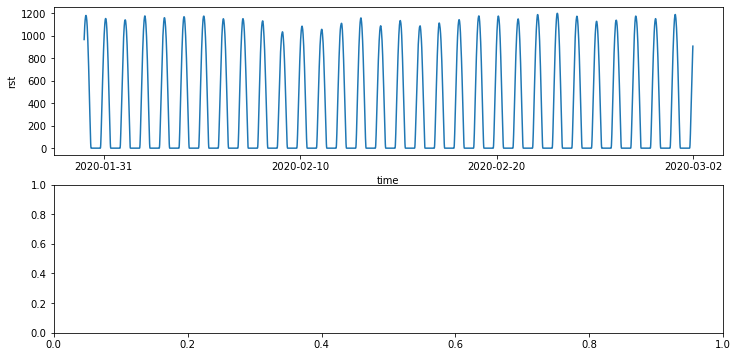

In [11]:
# um_swn = um_swd-um_swu
fig, ax = plt.subplots(2,1,figsize=(12,6))
sc_swn.mean(axis=(1)).plot(label="SW net", ax=ax[0])
sc_swu.mean(axis=(1)).plot(label="upwelling SW", ax=ax[0])
sc_swd.mean(axis=(1)).plot(label="downwelling SW", ax=ax[0])
# ge_swd.mean(axis=(1,2)).plot(label="GEOS downwelling SW", linestyle="--", ax=ax[0])
sc_alb = (ge_swu/ge_swd)
sc_alb.where(sc_alb.time.dt.hour<5).mean(axis=(1)).plot(ax=ax[1], label="alb") 
axt=ax[1].twinx()
sc_olr.mean(axis=(1)).plot(ax=axt, color="C1", label="OLR")
ax[1].legend(loc="upper left")
axt.legend(loc="upper right")
ax[1].set_ylabel("albedo")
ax[1].set_ylim([0,0.8])
fig.suptitle("SCREAM TWP")
ax[0].legend()
plt.savefig("../plots/scream_native_twp-swd-swn-swu.png", dpi=120)
plt.show()

In [14]:
sc_alb

<xarray.DataArray (time: 453, ncells: 61250, grid_size: 61250)>
dask.array<truediv, shape=(453, 61250, 61250), dtype=float32, chunksize=(453, 6125, 61250), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) object 2020-01-30 00:00:00 ... 2020-02-04 00:00:00
    lon              (ncells) float64 dask.array<chunksize=(6125,), meta=np.ndarray>
    lat              (ncells) float64 dask.array<chunksize=(6125,), meta=np.ndarray>
    grid_center_lon  (grid_size) float64 dask.array<chunksize=(61250,), meta=np.ndarray>
    grid_center_lat  (grid_size) float64 dask.array<chunksize=(61250,), meta=np.ndarray>
Dimensions without coordinates: ncells, grid_size

In [12]:
da_olr.shape, da_alb.shape, da_swu.shape, da_swd.shape

((2184, 10, 10), (2184, 10, 10), (2184, 10, 10), (2184, 10, 10))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
45500
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  3.2s
48393600
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  9.7s
39168000
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.6s
4558200
[########################################] | 100% Completed | 52.7s
[########################################] | 100% Completed |  2min 11.3s
66063360
[########################################] | 100% Completed |  1.8s
[#####                                   ] | 12% Completed |  1.2s


MemoryError: Unable to allocate 633. GiB for an array with shape (453, 6125, 61250) and data type float32

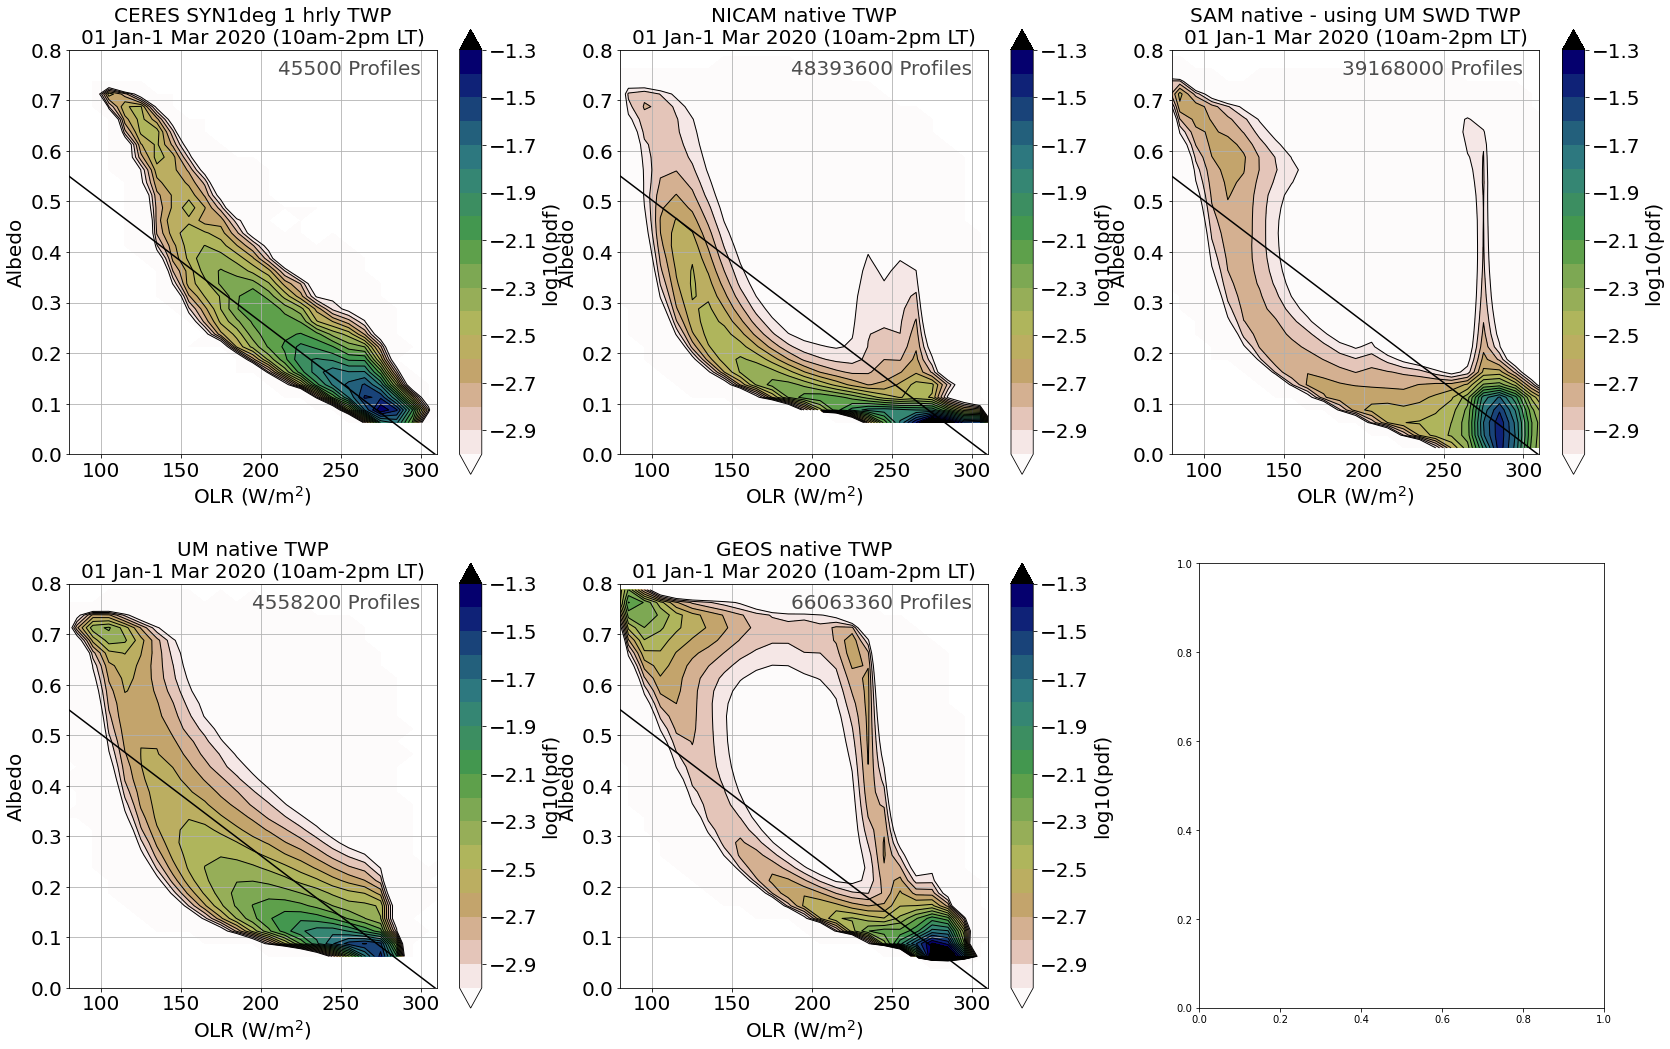

In [13]:
# models=["CERES SYN1deg 1 hrly", "NICAM 1x1", "SAM 1x1 - using GEOS SWD", "UM 1x1", "GEOS 1x1", "SCREAM 1x1"]
# models=["CERES SYN1deg 1 hrly", "NICAM 0.25deg", "SAM 0.25deg - using GEOS SWD", "UM 0.25deg", "GEOS 0.25deg", "SCREAM 0.25 deg"]
models=["CERES SYN1deg 1 hrly", "NICAM native", "SAM native - using UM SWD", "UM native", "GEOS native", "SCREAM native"]
fig = plt.figure(figsize=(28,18))
axes = [fig.add_subplot(2,3,i,box_aspect=1.1) for i in range(1,len(models)+1)]
i = 0
olrs=[da_olr, ni_olr, sa_olr, um_olr, ge_olr, sc_olr]
albs=[da_alb, ni_alb, sa_alb, um_alb, ge_alb, sc_alb]
for i in range(len(olrs)):
    olr = olrs[i]
    alb = albs[i]
    olr = olr.where((olr.time.dt.hour>=0)&(olr.time.dt.hour<=4))
    alb = alb.where((alb.time.dt.hour>=0)&(alb.time.dt.hour<=4))
    util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                ax=axes[i], model=models[i], region=region, cmap="gist_earth_r")
    axes[i].set_xlabel("OLR (W/m$^2$)")
    axes[i].set_ylabel("Albedo")
    axes[i].grid(True)
    axes[i].set_ylim([0,0.8])
    axes[i].set_title("{} {}\n01 Jan-1 Mar 2020 (10am-2pm LT)".format(models[i], region), fontsize=20)
    i+=1
plt.savefig("../plots/TWP/jhistnative_{}.png".format(region))
plt.show()

In [11]:
print("DATA:   " + str(int(da_olr.mean().values)) + "   " + str(da_alb.where(da_alb.time.dt.hour<4).mean().values)+\
      "\nNICAM:  " + str(int(ni_olr.mean().values)) + "   " + str(ni_alb.where(ni_alb.time.dt.hour<4).mean().values)+\
      "\nSAM:    " + str(int(sa_olr.mean().values)) + "   " + str( sa_alb.where(sa_alb.time.dt.hour<4).mean().values)+\
      "\nUM:     " + str(int(um_olr.mean().values)) + "   " + str(um_alb.where(um_alb.time.dt.hour<4).mean().values)+\
      "\nGEOS:   " + str(int(ge_olr.mean().values)) + "   " + str(ge_alb.where(ge_alb.time.dt.hour<4).mean().values)+\
      "\nSCREAM  " + str(int(sc_olr.mean().values)) + "   " + str(sc_alb.where(sc_alb.time.dt.hour<4).mean().values)
     )


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.8s


NameError: name 'sc_alb' is not defined

# GEOS high albedo high OLR values

In [20]:
ge_iwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clivi", "TWP")).clivi
ge_lwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clwvi", "TWP")).clwvi
ge_iwp, ge_lwp

(<xarray.DataArray 'clivi' (time: 3253, lat: 40, lon: 40)>
 [5204800 values with dtype=float32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-30 ... 2020-03-03T21:00:00
   * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
   * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
 Attributes:
     standard_name:  atmosphere_mass_content_of_cloud_ice
     long_name:      ice_water_path
     units:          kg m-2
     origin:         IWP,
 <xarray.DataArray 'clwvi' (time: 3253, lat: 40, lon: 40)>
 [5204800 values with dtype=float32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-30 ... 2020-03-03T21:00:00
   * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
   * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
 Attributes:
     standard_name:  atmosphere_mass_content_of_cloud_condensed_water
     long_name:      liquid_water_path
     units:          kg m-2
     origin

In [27]:
t = 2867
for t in range(t,t+25):
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    
    ge_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
    ge_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
    ax[0,0].annotate("Mean OLR={}".format(int(ge_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
    ax[0,1].annotate("Mean Alb={0:0.2g}".format((ge_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

    print(ge_olr[t].mean().values, ge_alb[t].mean().values)

    ge_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0])
    ge_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
    ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((ge_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
    ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
    plt.savefig("../plots/TWP/GEOS-albolriwplwp/g{0:0>4}.png".format(t))
    plt.close()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
205.94269 0.4924331
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
204.89384 0.48051655
[######